In [1]:
# Just importing stuff and setting-up matplolib
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib as mpl
from scipy.optimize import minimize
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1.5
mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')
rc("axes", labelsize = "large")
def cm2inch(value):
    return value/2.54
def cm2inch(value):
    return value/2.54
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
def pdf(data, bins = 10, density = True):
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

# Experimental force measurement

In this notebook, we are gonna compute the force felt by our particle, experimentaly using the data of the preprint.

In the first part we will measure the force using the experimentaly measured potential.

On the second part we will use the local drifts and check if everything match.

In [2]:
# Define logarythmic histrogram in order to have more points near the surface.
def logarithmic_hist(data,begin,stop,num = 50,base = 2):
    
    if begin == 0:
        beg = stop/num
        bins = np.logspace(np.log(beg)/np.log(base), np.log(stop)/np.log(base), num-1, base=base)
        widths = (bins[1:] - bins[:-1])
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0],bins))
        widths = (bins[1:] - bins[:-1])
    
    else:
        bins = np.logspace(np.log(begin)/np.log(base), np.log(stop)/np.log(base), num, base=base)
        widths = (bins[1:] - bins[:-1])
    
    hist,bins = np.histogram(data, bins=bins,density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1])/2
    
    return bins_center,widths, hist

Data loading

In [20]:
raw_data = loadmat("data_graphs.mat")
z_exp = np.squeeze(raw_data["z"]) *1e-6
z_exp = z_exp - np.min(z_exp)

In [21]:
# We compute the PDF
z_hist, _, P_z= logarithmic_hist(z_exp, 39e-9, 2e-6, num=50)
P_z = P_z / np.trapz(P_z, z_hist)

Text(0, 0.5, '$P_{eq}(z)$')

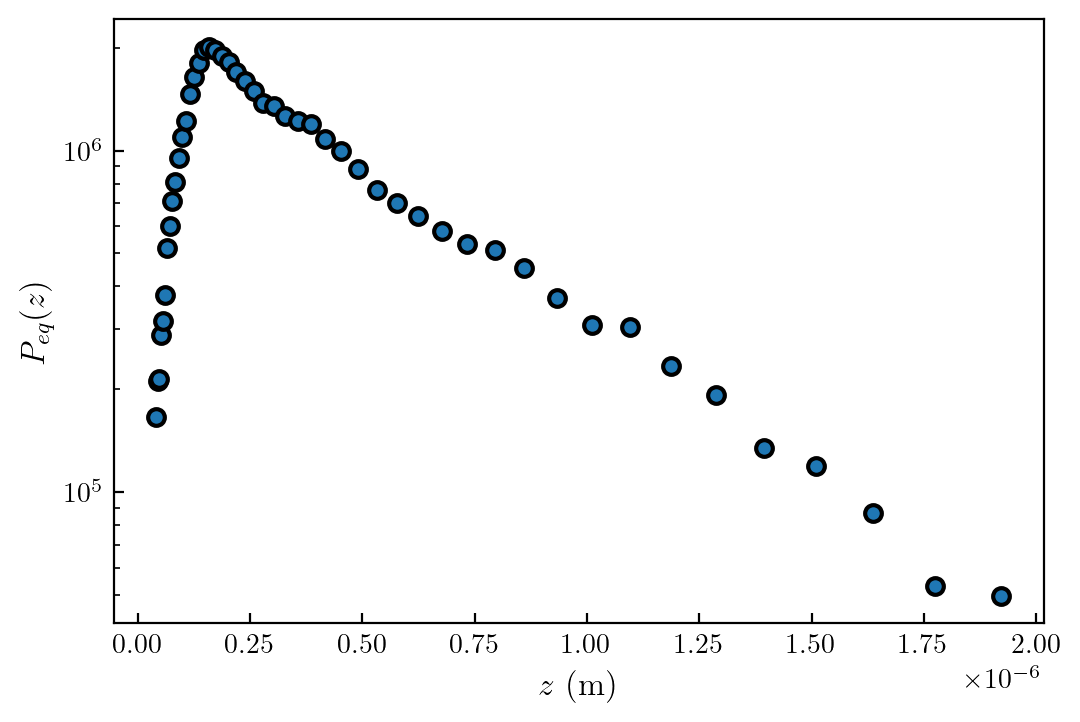

In [22]:
# Just a plot of the PDF
plt.semilogy(z_hist, P_z, "o")
plt.xlabel("$z$ (m)")
plt.ylabel("$P_{eq}(z)$")

To compute de force we then avec to take the derivative of $\mathrm{log}(P_{eq})$ 

In [23]:
F_eq =  np.gradient(np.log(P_z), z_hist) * 4e-21
#F_eq = (P_z[1:] - P_z[:-1]) / (z_hist[1:] - z_hist[:-1])

We want now to compare with the results of the force that can be computed from the result of the multifit, which gives us a good measurement of the following parameters.

B = 4.5
ld = 21 nm
lb = 532 nm

In [24]:
B = 4.8
ld = 20.8e-9
lb = 532e-9


In [25]:
z_F_th = np.linspace(20e-9,3e-6,10000)
# just a function to compute the theoritical force from the results of the multifit
f_th = lambda z:4e-21 * ( B/(ld) * np.exp(- z/(ld)) - 1/(lb))

F_th = f_th(z_F_th)


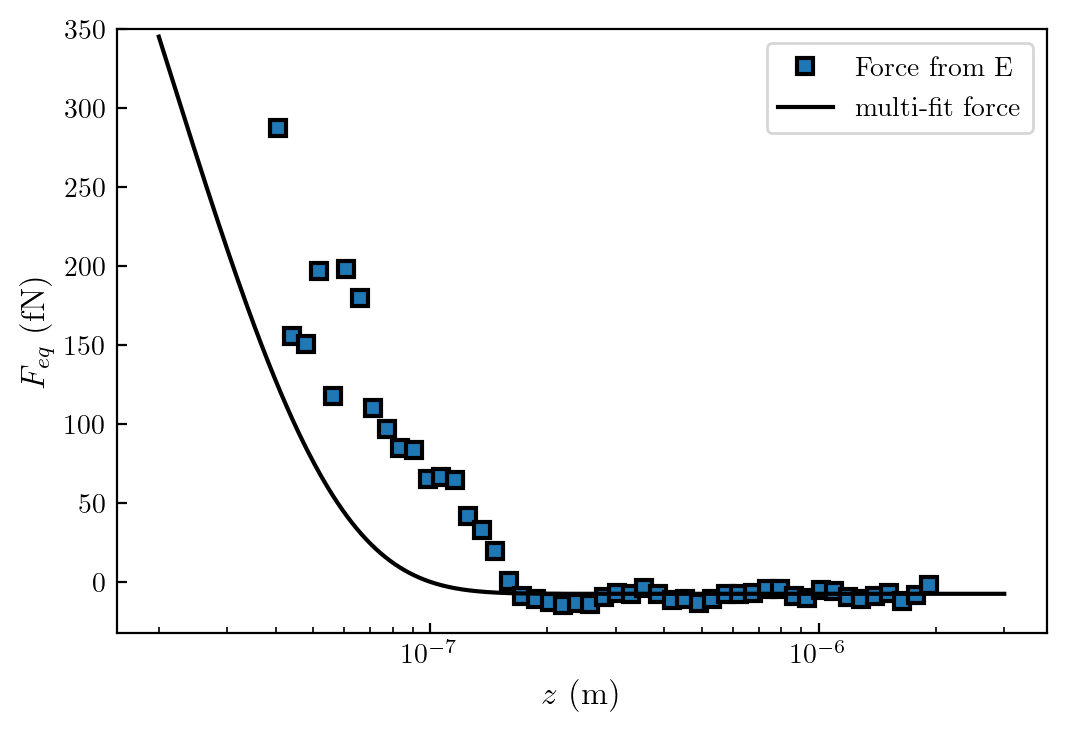

In [26]:
plt.semilogx(z_hist, F_eq * 1e15, "s", label = "Force from E")
plt.plot(z_F_th, F_th * 1e15, color = "k", label = "multi-fit force")
plt.xlabel("$z$ (m)") 
plt.ylabel("$F_{eq}$ (fN)")
plt.ylim((None,350))
plt.legend()
plt.show()

We see that there is an offset to take into account on $z$, to correctly take in into account we need to measure it correctly. in order to do it, i'll directly do a function that compute the $\chi ^2$ as a function of the offset that we apply on the trajectory.

As a reminder we do have this offset due to the way the holographic method we use. This method method mesure the distance between the imaging plane of the objective and the particle but not between the surface and the particle that we have to deduce form the data.

In [31]:
def chi_2_force(offset):
    """ Function that permits to directly measure the chi 2 as a function as the offset on the trajectory"""
    offset = offset * 1e-9
    z = np.squeeze(raw_data["z"]) *1e-6
    z = z-np.min(z)
    z = z-offset
    z_hist, _, P_z= logarithmic_hist(z, 39e-9, 2e-6, num=20)
    F_eq =  np.gradient(np.log(P_z), z_hist) * 4e-21
    #return z_hist, P_z
    return np.mean((F_eq*1e15 - f_th(z_hist)*1e15) ** 2)

    
    
    

In [32]:
z_chi2 = np.linspace(1, 200, 30)
chi_2 = [chi_2_force(i) for i in z_chi2]

Text(0, 0.5, '$\\chi ^2 / max(\\chi^2) $')

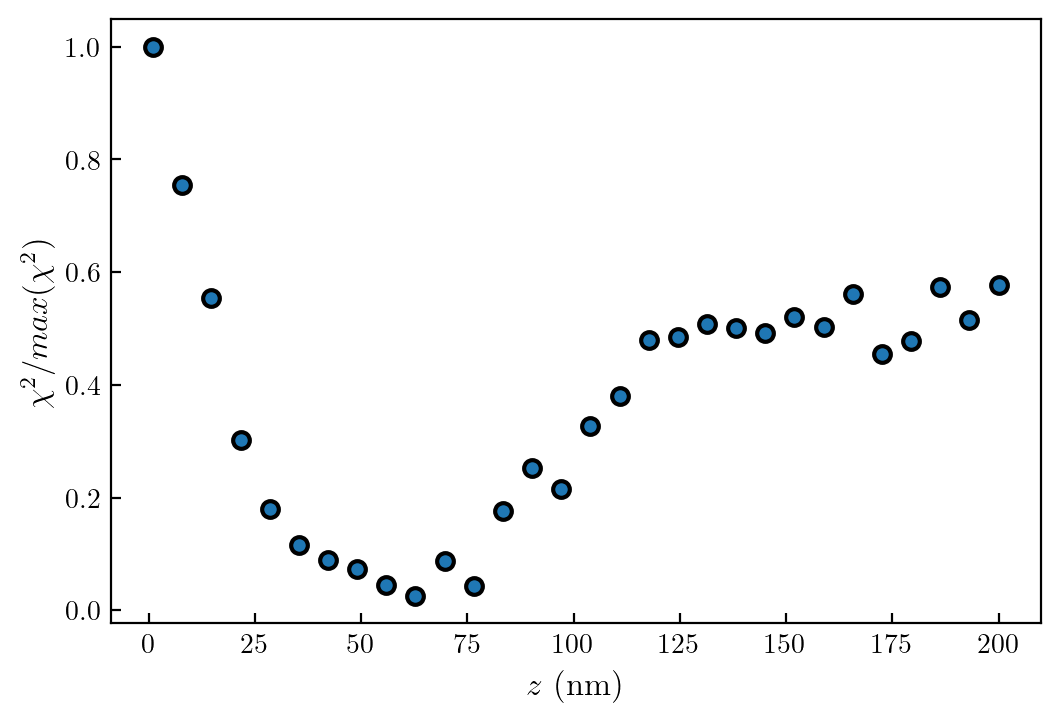

In [33]:
plt.plot(z_chi2, chi_2 / max(chi_2), "o")
plt.xlabel("$z$ (nm)")
plt.ylabel("$\chi ^2 / max(\chi^2) $")

Okay ! we see that we have a minimum around $62.5$ nanometers, let's have a better measurement with the minimize algorithm ! 

In [34]:
minimize(chi_2_force, x0 = 62.5,  method='Nelder-Mead', tol=1e-40)

 final_simplex: (array([[61.95602417],
       [61.95602417]]), array([25.38935383, 25.38935383]))
           fun: 25.389353833953738
       message: 'Optimization terminated successfully.'
          nfev: 143
           nit: 52
        status: 0
       success: True
             x: array([61.95602417])

we see that the offset sould be equal to $62 ~ \mathrm{nm}$. Giving the following force :

In [37]:
offset = 62 * 1e-9
z = np.squeeze(raw_data["z"]) *1e-6
z = z-np.min(z)
z = z-offset
z_hist, _, P_z= logarithmic_hist(z, 39e-9, 2e-6, num=50)
F_eq =  np.gradient(np.log(P_z), z_hist) * 4e-21

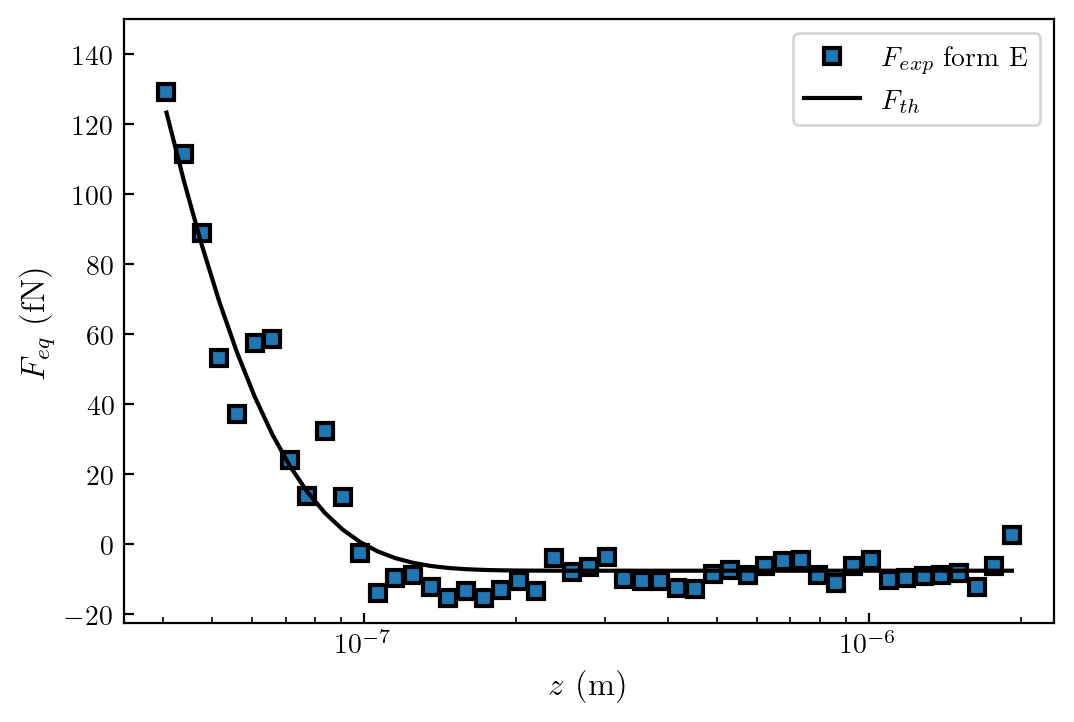

In [38]:
plt.semilogx(z_hist, F_eq * 1e15, "s", label = "$F_{exp}$ form E")
#plt.plot(z_F_th, F_th * 1e15, color = "k")
plt.plot(z_hist, f_th(z_hist) * 1e15, color = "k", label = "$F_{th}$")
plt.xlabel("$z$ (m)") 
plt.ylabel("$F_{eq}$ (fN)")
plt.ylim((None,150))
plt.legend()
plt.show()

Now that we have verified that we corectly get the forces from the equilibrium probability density of height that permited us to measure the offset on the trajectory. 

Now that everything is set up correctly we can try to measure the forces from the local drifts.

## Force measurement from the local drifts

In order to measure the forces from the local drifts we are gonna use some moving average magiK. This will permit us to have a quasi continuous measurement.

Bascicaly, the measurement is done in a few steps :

* Compute the volocity array `(x[1:] - x[0:-1])/dt `

* Sort the velocity and the height in the height order.

* Do a moving average on the velocity

* Compute the force : $F(z) = 6 \pi \eta(z) a \langle v \rangle $

* Apply the correction due to the Itö convention on the force $ \propto - \frac{dD}{D}$




In [39]:
def movmean(x, w):
    """ Moving average function using convolution """
    return np.convolve(x, np.ones(w), 'same') / w

def movstd(x,w):
    mean = movmean(x,w)
    new_x = (x - mean)**2
    return np.sqrt(movmean(new_x, w))

def F_correction(alpha,z):
    """ Function to compute the correction on the force measurement due to the ito convention"""
    return - 4e-21 * alpha *(42*a*z*z + 24*a*a*z + 4*a*a*a)/(36*(z**4) + 66*a*(z**3) + 30*a*a*z*z + 4*(a**3)*z)
def eta(z):
    """visosity along the z axis -- utlity function to measure the forces"""
    result = ((6*z*z + 2*a*z) / (6*z*z + 9*a*z + 2*a*a))
    return 1/result

In [42]:
z_drifts = np.squeeze(raw_data["z"]) *1e-6
z_drifts = z_drifts - np.min(z_drifts) - offset

In [43]:
# On calcul les vitesses:
dt = 1/60 # 60 fps
v = (z_drifts[1:] - z_drifts[:-1]) / dt
z_drifts = z_drifts[:-1] # Convention Itö -> on attribue la vitesse a z_1
v = v[z_drifts.argsort()] # on tri les vitesse en fonction de la hauteur
z_drifts = np.sort(z_drifts) # on tri les hauteurs.



We can also compute the error on the force :

\begin{equation}
Err_f = \sqrt{24 \pi k_\mathrm{B} T \eta_z(z) a / \tau_{box} }
\end{equation}

with $\tau_{box} = w_{average} / \mathrm{fps}$, $w_{average}$ being the width of the moving average.

In [44]:
# Let's do some moving average magic ! ;)
w = 1500
a = 1.516e-6
F_drifts = 6 * np.pi * 0.001 * eta(z_drifts) * a * movmean(v, w)
F_drifts = F_drifts + F_correction(1, z_drifts)
#F_err = np.sqrt(24 * np.pi * 4e-21 *0.001*  eta(z_drifts) * a / (w*dt))
F_exp_err = 6 * np.pi * 0.001 * eta(z_drifts) * a * movstd(v, w)
z_th = np.linspace(10e-9, 4e-6, 1000)

F_err_th = np.sqrt(24 * np.pi * 4e-21 *0.001*  eta(z_th) * a / (w*dt))
F_drift_th = f_th(z_th)

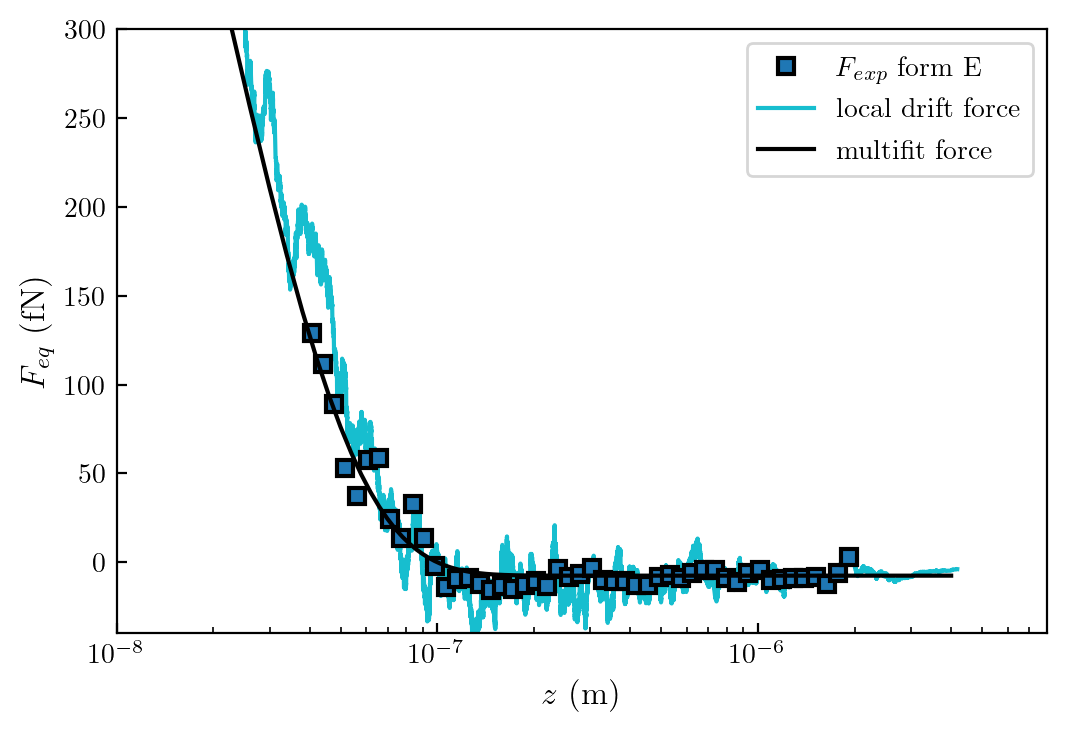

In [45]:
plt.semilogx(z_hist, F_eq * 1e15, "s", label = "$F_{exp}$ form E", zorder = 10)
plt.plot(z_drifts, F_drifts * 1e15, color = "tab:cyan", label = "local drift force")
plt.semilogx(z_th, F_drift_th  * 1e15, color = "k", zorder = 11, label="multifit force")
#plt.fill_between(z_drifts, F_drifts * 1e15 - F_exp_err*1e15, F_drifts * 1e15 + F_exp_err*1e15, alpha = 0.5, color = "tab:purple", label="drift force error")
plt.ylim((-40, 300)) 
plt.xlim((10e-9,None))
plt.legend()
plt.xlabel("$z$ (m)") 
plt.ylabel("$F_{eq}$ (fN)")
plt.show()

same plot but with fewer points


In [46]:
plt.plot(z_hist, F_eq * 1e15, "s", label = "$local form U", zorder = 10)
plt.errorbar(z_drifts[::2000],F_drifts[::2000] * 1e15,linestyle="", marker="o", label = "local drift force")
plt.semilogx(z_th, F_drift_th  * 1e15, color = "k", zorder = 11, label="multifit force")
plt.fill_between(z_th, F_drift_th  * 1e15 -F_err_th*1e15, F_drift_th  * 1e15 + F_err_th*1e15, alpha = 0.2, color ="k")
plt.plot(z_th, F_drift_th  * 1e15 -F_err_th*1e15, "--" ,color ="k")
plt.plot(z_th, F_drift_th  * 1e15 +F_err_th*1e15, "--", color ="k")

plt.ylim((-40, 300)) 
plt.xlim((10e-9,None))
plt.xlabel("$z$ (m)") 
plt.ylabel("$F$ (fN)")
plt.legend()
plt.show()

RuntimeError: latex was not able to process the following string:
b'$local form U'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (MiKTeX 21.6.28)
entering extended mode
(C:/Users/m.lavaud/.matplotlib/tex.cache/491432c36abbd6867e4b3b6e91dacc93.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-06-18>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\m.lavaud\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\m.lavaud\AppData\Roaming\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\m.lavaud\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\m.lavaud\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.cfg)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
(491432c36abbd6867e4b3b6e91dacc93.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.19 {\rmfamily $local form U}
                              
No pages of output.
Transcript written on 491432c36abbd6867e4b3b6e91dacc93.log.
latex: major issue: User/administrator updates are out-of-sync.




<Figure size 1200x800 with 1 Axes>

In [47]:
offset*1e6

0.062

Finaly, everything seems to work, we do measure a sligtly higher from the drifts but it could simply be explain from a error on the offset of 5 nanometers.

In [51]:
z = np.squeeze(raw_data["z"]) *1e-6
z = z - np.min(z) - offset*1e6

bins_center_pdf_z, widths, hist = logarithmic_hist(z, 39e-3, 3, num = 100, base=2)
z_F_exp = (bins_center_pdf_z - widths/2) * 1e-6
z_F_exp = z_F_exp[:-1]
fps = 60


def Dz_z(z,off):
    off =(off * 1e-6)
    z = z - off
    result = ((6*z*z + 2*a*z) / (6*z*z + 9*a*z + 2*a*a))
    return result

def vzz(Y, z,times=[1], method = "anti-Ito"):
    
    # We frist get all the different variables of the problem
    Y = Y * 1e-6
    z_z = z * 1e-6

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.      
    # We initialize the variable used to store the results.
    # For the diffusion coefficient itself.
    vz = np.zeros((len(times), len(Y[:-1])))

    # For the error
    errvz = np.zeros((len(times), len(Y[:-1])))
    
    
    for n, i in enumerate(times):
        
        # Conpute the Delta x = x(Dt + t) - x(t) for given Dt -- same over y
        if method == "Ito" or method == "anti-Ito":
            Dzs = z_z[i:] - z_z[0:-i]
            Dzs = Dzs + F_correction(1,z[0:-i])/(6*np.pi*0.001*a*Dz_z(z[0:1],0))
            
        if method == "Stratanovich":
            Dzs = z_z[2*i:] - z_z[0:-2*i] 
        #Dzs = z_z[0:-i] - z_z[i:]
        # Now for each z-bin we are going to measure the diffusion coefficient.
        
        for m in range(len(Y)-1):
            #print(len(Dzs))
            #print(len(z[i:]))
            # We take the Dx corresponding the actual bin 
            if method == "anti-Ito":        
                dz = Dzs[(z_z[i:] > Y[m]) & (z_z[i:] < Y[m+1])]
            if method == "Ito":
                dz = Dzs[(z_z[:-i] > Y[m]) & (z_z[:-i] < Y[m+1])]
            if method == "Stratanovich":
                dz = Dzs[(z_z[i:-i] > Y[m]) & (z_z[i:-i] < Y[m+1])]
            
            if method == "Ito" or method == "anti-Ito":   
                vz[n,m] = np.mean(dz)/(i/fps)
            if method == "Stratanovich":
                vz[n,m] = np.mean(dz)/(2*i/fps)
            #errvz[n,m] = np.std(dz)/(i/fps)
            errvz[n,m] = len(dz)
    err_vz = np.nanmean(errvz, axis=0)
    vz = np.nanmean(vz, axis=0)
          
    return vz, err_vz

def F_corr(alpha,z):
    return -alpha * D(z) * 4e-21 * D_1_prime(z)

def D_1_prime(z):
    return (2 * r * (2 * r**2 + 12 * r * z + 21 *  z**2))/(2 * r** + 9 * r * z + 6 * z**2)**2

def D(z):
    return (6*z**2 + 9*r*z + 2*r**2) / (6*z**2 + 2 * r * z)

def F_corr(alpha,z):
    return -alpha * D(z) * 4e-21 * D_1_prime(z)
def F_corr(alpha,z):
    return - 4e-21 * alpha *(42*a*z*z + 24*a*a*z + 4*a*a*a)/(36*(z**4) + 66*a*(z**3) + 30*a*a*z*z + 4*(a**3)*z)



C:\Users\m.lavaud\.conda\envs\analyse\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [53]:
a = 1.51e-6
vz_ito, err_ito = vzz(np.array([1,2,3,4,5,6]),z, method = "Ito")
#z_F_exp = bins_center_pdf_z[:-1] * 1e-6
F_exp_ito = 6 * np.pi  * 0.001 * a * vz_ito/ Dz_z(z_F_exp, 0) + F_corr(1,z_F_exp)
F_err_ito = 6 * np.pi  * 0.001 * a * err_ito/ Dz_z(z_F_exp, 0) + F_corr(1,z_F_exp)

<ipython-input-51-1adc9275cac5>:62: RuntimeWarning: Mean of empty slice
  vz = np.nanmean(vz, axis=0)


ValueError: operands could not be broadcast together with shapes (5,) (98,) 

In [54]:
F

NameError: name 'F' is not defined

In [55]:
plt.errorbar(z_F_exp, F_exp_ito * 1e15,yerr=F_err_ito*1e15/2,xerr=widths[:-1]/2*1e-6, marker = "o", linestyle="")
plt.plot(z_hist, F_eq * 1e15, "s", label = "$F_{exp}$ form E", zorder = 10)
plt.semilogx(z_th, F_drift_th  * 1e15, color = "k", zorder = 11, label="multifit force")
#plt.fill_between(z_th, F_drift_th  * 1e15 -F_err_th*1e15, F_drift_th  * 1e15 + F_err_th*1e15, alpha = 0.2, color ="k")
#plt.plot(z_th, F_drift_th  * 1e15 -F_err_th*1e15, "--" ,color ="k")
#plt.plot(z_th, F_drift_th  * 1e15 +F_err_th*1e15, "--", color ="k")

plt.ylim((-40, 300)) 
plt.xlim((10e-9,None))
plt.xlabel("$z$ (m)") 
plt.ylabel("$F$ (fN)")
plt.legend()
plt.show()

NameError: name 'F_exp_ito' is not defined

In [56]:
len(bins_center_pdf_z)

99

# Froce error

Now we would like to compute the stochastic error on the force.

In [84]:
def random_on_force():
    z = np.squeeze(raw_data["z"]) 
    z = z - np.min(z) - offset*1e6
    bins_center_pdf_z, widths, hist = logarithmic_hist(z, 39e-3, 3, num = 45, base=2)
    z = z + np.random.normal(0, 1e-3, len(z))
    z_F_exp = (bins_center_pdf_z - widths/2) * 1e-6
    z_F_exp = z_F_exp[:-1]
    a = 1.51e-6
    vz_ito, err_ito = vzz(bins_center_pdf_z, z, [1,2], method = "Ito")
    #z_F_exp = bins_center_pdf_z[:-1] * 1e-6
    F_exp_ito = 6 * np.pi  * 0.001 * a * vz_ito/ Dz_z(z_F_exp, 0) + F_corr(1,z_F_exp)
    return F_exp_ito, err_ito
    

In [85]:
len(z_F_exp)

43

In [86]:
len(random_on_force()[0])

43

In [87]:
bins_center_pdf_z, widths, hist = logarithmic_hist(z, 39e-3, 3, num = 45, base=2)
z = z + np.random.normal(0, 1e-3, len(z))
z_F_exp = (bins_center_pdf_z - 1*widths/2) * 1e-6
z_F_exp = z_F_exp[:-1]

N = 100
all_F = np.ones((len(random_on_force()[0]),N))
all_err_F = np.ones((len(random_on_force()[0]),N))

for i in range(N):
    F, err = random_on_force()
    all_F[:,i] = F
    all_err_F[:,i] = err
    
    
    

In [88]:
F_meaned = np.mean(all_F, axis=1)
F_err_tot = np.std(all_F, axis=1)


In [89]:
T_boxes = np.mean(all_err_F, axis=1)

In [90]:
#plt.plot(z_F_exp, T_boxes)

In [91]:
f_th2 = f_th(z_F_exp)
F_err_th = np.sqrt(24 * np.pi * 4e-21 *0.001*  eta(z_F_exp) * a / (T_boxes*dt))


In [92]:
[3]*4

[3, 3, 3, 3]

In [93]:
f_th

<function __main__.<lambda>(z)>

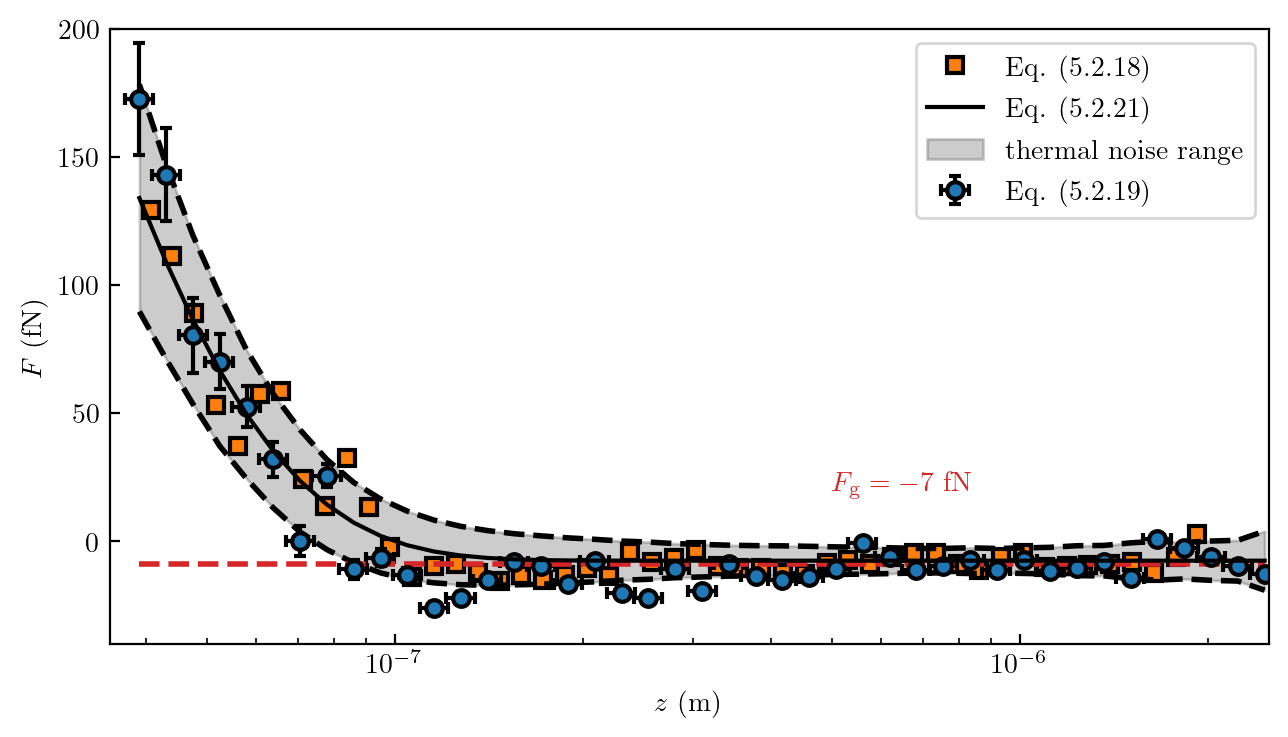

In [95]:
plt.figure(figsize=( cm2inch(16),cm2inch(9)))

plt.errorbar(z_F_exp, F_meaned*1e15, yerr=F_err_tot*1e15,xerr = widths[:-1]*1e-6/2 ,marker = "o", linestyle="", ecolor="k", capsize = 2, label = "Eq. (5.2.19)")
#plt.plot(z_hist, F_eq * 1e15, "s", label = "$F_{exp}$ form E", zorder = 10)
plt.fill_between(z_F_exp, f_th2  * 1e15 -F_err_th*1e15, f_th2  * 1e15 + F_err_th*1e15, alpha = 0.2, color ="k", label = "thermal noise range")
plt.plot(z_F_exp, f_th2  * 1e15 - F_err_th*1e15, "--" ,color ="k", linewidth = 2)
plt.plot(z_F_exp, f_th2  * 1e15 + F_err_th*1e15, "--" ,color ="k", linewidth = 2)
plt.plot(z_hist, F_eq * 1e15, "s", label = "Eq. (5.2.18)", zorder = 1)

plt.plot(z_F_exp, [np.mean( F_meaned[5:]  * 1e15)]*len(z_F_exp), color = "tab:red", linestyle= "--", linewidth = 2)
plt.semilogx(z_F_exp, f_th2 * 1e15, color = "k", zorder = 11, label="Eq. (5.2.21)")

#plt.plot(z_th, F_drift_th  * 1e15 +F_err_th*1e15, "--", color ="k")
plt.text(5e-7, 20, "$F_\mathrm{g} = -7$ fN", color="tab:red", fontsize ="medium" )
plt.ylim((-40, 200)) 
plt.xlim((35e-9,2.5e-6))
plt.xlabel("$z$ (m)", fontsize="medium") 
plt.ylabel("$F$ (fN)", fontsize="medium")
plt.legend()
plt.tight_layout(pad=0.2)
plt.savefig("figure_force_total.pdf")
plt.show()

In [68]:
dict_force = {}
dict_force["z_F_exp"] = z_F_exp
dict_force["F_meaned"] = F_meaned
dict_force["widths"] = widths
dict_force["z_hist"] = z_hist
dict_force["f_th2"] = f_th2
dict_force["F_err_th"] = F_err_th
dict_force["F_err_tot"] = F_err_tot



import scipy
scipy.io.savemat("dict_force.mat", dict_force)


In [40]:
z_hist

array([4.06315748e-08, 4.40312392e-08, 4.77153552e-08, 5.17077230e-08,
       5.60341343e-08, 6.07225386e-08, 6.58032240e-08, 7.13090130e-08,
       7.72754741e-08, 8.37411520e-08, 9.07478164e-08, 9.83407320e-08,
       1.06568951e-07, 1.15485629e-07, 1.25148369e-07, 1.35619596e-07,
       1.46966957e-07, 1.59263756e-07, 1.72589435e-07, 1.87030080e-07,
       2.02678981e-07, 2.19637234e-07, 2.38014392e-07, 2.57929176e-07,
       2.79510240e-07, 3.02897003e-07, 3.28240548e-07, 3.55704600e-07,
       3.85466584e-07, 4.17718767e-07, 4.52669507e-07, 4.90544593e-07,
       5.31588707e-07, 5.76067002e-07, 6.24266819e-07, 6.76499538e-07,
       7.33102596e-07, 7.94441660e-07, 8.60912994e-07, 9.32946019e-07,
       1.01100608e-06, 1.09559747e-06, 1.18726667e-06, 1.28660587e-06,
       1.39425683e-06, 1.51091500e-06, 1.63733402e-06, 1.77433058e-06,
       1.92278972e-06])